In [2]:
import psycopg2
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Apertura de la base de datos

In [105]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

In [144]:
cur.execute("SELECT nfft, espectro, frec_central, frec_muestreo FROM radioastronomia_espectro WHERE (frec_central = 94000000 AND nfft=1024)")
rows = cur.fetchall()


In [145]:
nfft = rows[0][0]
espectro = rows[0][1]
frec_central = rows[0][2]
frec_muestreo = rows[0][3]

In [146]:
def promedio(espectro, nfft):
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    return x

In [147]:
cur.execute("SELECT nfft, espectro, frec_central, frec_muestreo FROM radioastronomia_espectro WHERE (frec_central = 102000000 AND nfft=1024)")
rows = cur.fetchall()
nfft1 = rows[0][0]
espectro1 = rows[0][1]
frec_central1 = rows[0][2]
frec_muestreo1 = rows[0][3]

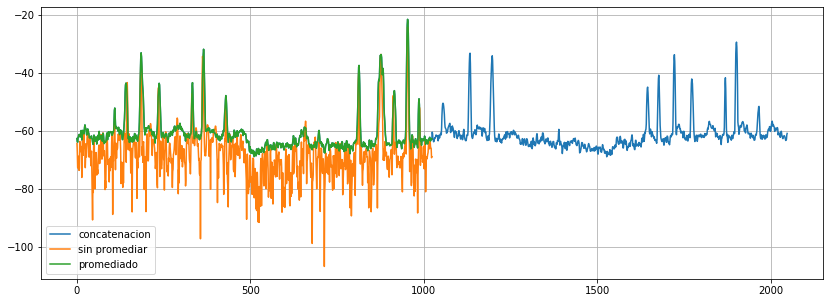

In [148]:
y = promedio(espectro1, nfft1)
x = promedio(espectro, nfft)
plt.figure(figsize=(14,5))
plt.plot(numpy.concatenate((x,y)), label="concatenacion")
plt.plot(espectro[0:1024], label="sin promediar")
plt.plot(x, label="promediado")
plt.legend()
plt.grid(True)

## querys para extraer barrido

seleccion de las frecuencias de muestreo, las frecuencias centrales
y el tamaño de la FFT, esto es para que el espectro seleccionado tenga las 
mismas características


In [150]:
cur.execute("SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;")
rows = cur.fetchall()
frec_central = []
for row in rows:
    frec_central.append(row[0])

cur.execute("SELECT DISTINCT frec_muestreo FROM radioastronomia_espectro;")
rows = cur.fetchall()
frec_muestreo = []
for row in rows:
    frec_muestreo.append(row[0])

cur.execute("SELECT DISTINCT nfft FROM radioastronomia_espectro;")
rows = cur.fetchall()
nfft = []
for row in rows:
    nfft.append(row[0])

print("frecuencia muestreo {}".format(frec_muestreo))
print("frecuencia central {}".format(frec_central))
print("tamano FFT {}".format(nfft))

frecuencia muestreo [16000000]
frecuencia central [78000000.0, 86000000.0, 94000000.0, 102000000.0, 110000000.0, 118000000.0, 126000000.0, 134000000.0, 142000000.0, 150000000.0, 158000000.0, 166000000.0, 174000000.0, 182000000.0, 190000000.0, 198000000.0, 206000000.0, 214000000.0, 222000000.0, 230000000.0, 238000000.0, 246000000.0]
tamano FFT [1024]


## seleccion de los tamaños de FFT

# Este es el generador de querys principal para crear el reporte

In [158]:
""" Esto hace un barrido de frecuencias """
df = pd.DataFrame(data=numpy.zeros(1024), columns=["X0"])
y = numpy.array([])
for frec_cen in frec_central:
    query = []
    query.append("SELECT espectro FROM radioastronomia_espectro ")
    query.append("WHERE (nfft = ")
    query.append(str(1024))
    query.append(" AND frec_muestreo = ")
    query.append(str(16000000))
    query.append(" AND frec_central = ")
    query.append(str(frec_cen))
    query.append(");")
    query = "".join(query)
            
    # extraccion del espectro
    cur.execute(query)
    rows = cur.fetchall()
    x_ = numpy.zeros(1024)
    for row in rows:
        espectro = row[0]
        espectro = numpy.asarray(espectro)
        x = promedio(espectro, 1024)
        x_ = x_ + x
    x_ = x_/len(rows)
    y = numpy.append(y,x)


In [159]:
f = numpy.linspace(70, 250, len(y))

Text(0, 0.5, 'Espectro')

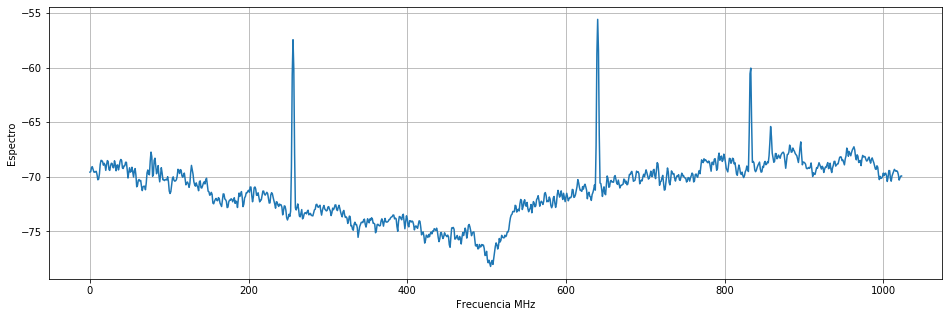

In [161]:
plt.figure(figsize=(16,5))
plt.plot(x_)
plt.grid(True)
plt.xlabel("Frecuencia MHz")
plt.ylabel("Espectro")

## Analisis de las caracteristicas

In [117]:
query = "SELECT * FROM radioastronomia_caracteristicasespectro WHERE (id=162);"
cur.execute(query)
rows = cur.fetchall()

In [118]:
id = rows[0][0]
max_v = rows[0][1]
max_v = numpy.asarray(max_v)
min_v = rows[0][2]
min_v = numpy.asarray(min_v)
energia = rows[0][4]
energia = numpy.asarray(energia)
df = pd.DataFrame(data=numpy.array([10*numpy.log10(energia), min_v, max_v]).T, columns=["ener_", "min_", "max_"])

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
ener_    24 non-null float64
min_     24 non-null float64
max_     24 non-null float64
dtypes: float64(3)
memory usage: 656.0 bytes


In [120]:
df.describe()

,ener_,min_,max_
count,24.000000,24.000000,24.000000
mean,-28.672289,-72.985731,-48.142010
std,1.184518,5.949826,1.823432
min,-33.283499,-96.656044,-55.033611
25%,-28.580415,-73.136965,-48.582391
50%,-28.244851,-71.123203,-47.801937
75%,-28.106702,-69.834974,-47.136701
max,-27.950923,-69.084419,-45.855053


In [121]:
df.head()

,ener_,min_,max_
0,-33.283499,-96.656044,-55.033611
1,-30.854049,-82.435837,-51.002083
2,-29.694556,-78.127678,-47.055714
3,-29.305123,-75.348656,-47.263485
4,-28.961298,-74.720078,-48.325962


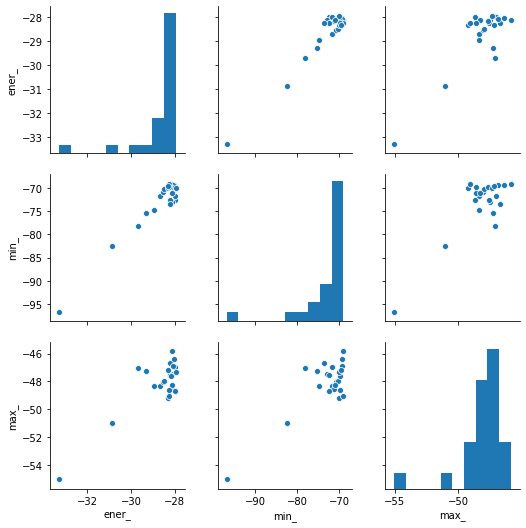

In [122]:
sns.pairplot(df)

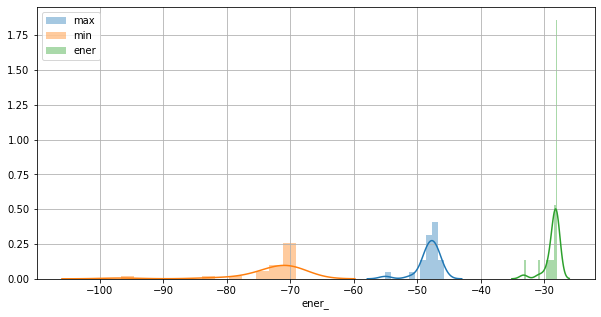

In [123]:
plt.figure(figsize=(10,5))
sns.distplot(df["max_"], label="max")
sns.distplot(df["min_"], label="min")
sns.distplot(df["ener_"], label="ener")
plt.grid(True)
plt.legend()

In [124]:
df.corr()

,ener_,min_,max_
ener_,1.000000,0.966114,0.829782
min_,0.966114,1.000000,0.809019
max_,0.829782,0.809019,1.000000


# 1) query obtencion de frecuencia

In [125]:
cur.execute("SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;")
rows = cur.fetchall()
frec_central = []
for row in rows:
    frec_central.append(row[0])


In [126]:
frec_central

[78000000.0,
 86000000.0,
 94000000.0,
 102000000.0,
 110000000.0,
 118000000.0,
 126000000.0,
 134000000.0,
 142000000.0,
 150000000.0,
 158000000.0,
 166000000.0,
 174000000.0,
 182000000.0,
 190000000.0,
 198000000.0,
 206000000.0,
 214000000.0,
 222000000.0,
 230000000.0,
 238000000.0,
 246000000.0]

# 2) query para obtener los ID

In [127]:
query = "SELECT id FROM radioastronomia_espectro WHERE (frec_central=78000000);"
cur.execute(query)
rows = cur.fetchall()

# 3) query para obtener las caracteristicas

In [128]:
query = "SELECT id, max_v, min_v, espectro_id, energia FROM radioastronomia_caracteristicasespectro WHERE espectro_id IN (317, 339, 361, 364);"
cur.execute(query)
rows = cur.fetchall()

In [129]:
a = []
for i in rows:
    a.append(i[0])
a = tuple(a)
query =[]
query.append("SELECT id, max_v, min_v, espectro_id, energia FROM radioastronomia_caracteristicasespectro WHERE espectro_id IN ")
query.append(str(a))
query.append(";")
query = "".join(query)
print(query)
cur.execute(query)
rows = cur.fetchall()

SELECT id, max_v, min_v, espectro_id, energia FROM radioastronomia_caracteristicasespectro WHERE espectro_id IN (162, 206, 209, 184);


In [130]:
mu = 0
for row in rows:
    id = row[0]
    max_v = row[1]
    max_v = numpy.asarray(max_v)
    min_v = row[2]
    min_v = numpy.asarray(min_v)
    energia = row[4]
    energia = numpy.asarray(energia)
    mu = mu + numpy.mean(energia)
mu = mu/len(rows)
mu = 10*numpy.log10(mu)

ZeroDivisionError: division by zero

In [131]:
df.head()

,ener_,min_,max_
0,-33.283499,-96.656044,-55.033611
1,-30.854049,-82.435837,-51.002083
2,-29.694556,-78.127678,-47.055714
3,-29.305123,-75.348656,-47.263485
4,-28.961298,-74.720078,-48.325962


# Analisis de caracteristicas

In [138]:
car_e = numpy.array([])
for f in frec_central:
    #extraccion de ids referentes a las muestras
    query = []
    query.append("SELECT id FROM radioastronomia_espectro WHERE (frec_central=")
    query.append(str(f))
    query.append(");")
    query = "".join(query)
    cur.execute(query)
    rows = cur.fetchall() #las filas que contienen los ids
    # extraccion del espectro respecto a los ids obtenidos
    a = []
    for i in rows:
        a.append(i[0])
    a = tuple(a)
    query =[]
    query.append("SELECT id, max_v, min_v, espectro_id, energia FROM radioastronomia_caracteristicasespectro WHERE espectro_id IN ")
    query.append(str(a))
    query.append(";")
    query = "".join(query)
    cur.execute(query)
    rows = cur.fetchall() #las filas que contienen los espectros
    
    mu = 0
    for row in rows:
        id = row[0]
        max_v = row[1]
        max_v = numpy.asarray(max_v)
        min_v = row[2]
        min_v = numpy.asarray(min_v)
        energia = row[4]
        energia = numpy.asarray(energia)
        mu = mu + numpy.mean(energia)
    mu = mu/len(rows)
    mu = 10*numpy.log10(mu)
    car_e= numpy.append(car_e, mu)

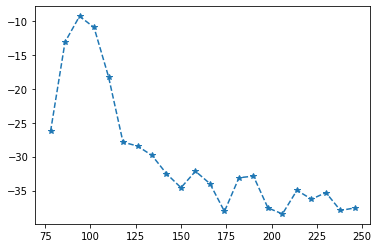

In [139]:
frec_central = numpy.asarray(frec_central)
plt.plot(frec_central/1e6, car_e, "--*")